In [87]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew, chi2, probplot

N = 23
cols = [
    'Daily_Usage_Hours', 'Sleep_Hours', 'Exercise_Hours',
    'Screen_Time_Before_Bed', 'Time_on_Social_Media',
    'Time_on_Gaming', 'Time_on_Education'
]
col = cols[N % 7]
print(col)

df = pd.read_csv('../datasets/teen_phone_addiction_dataset.csv')
data = df[col].dropna()

df.head()

Exercise_Hours


,ID,Name,Age,Gender,Location,School_Grade,Daily_Usage_Hours,Sleep_Hours,Academic_Performance,Social_Interactions,...,Screen_Time_Before_Bed,Phone_Checks_Per_Day,Apps_Used_Daily,Time_on_Social_Media,Time_on_Gaming,Time_on_Education,Phone_Usage_Purpose,Family_Communication,Weekend_Usage_Hours,Addiction_Level
0,1,Shannon Francis,13,Female,Hansonfort,9th,4.0,6.1,78,5,...,1.4,86,19,3.6,1.7,1.2,Browsing,4,8.7,10.0
1,2,Scott Rodriguez,17,Female,Theodorefort,7th,5.5,6.5,70,5,...,0.9,96,9,1.1,4.0,1.8,Browsing,2,5.3,10.0
2,3,Adrian Knox,13,Other,Lindseystad,11th,5.8,5.5,93,8,...,0.5,137,8,0.3,1.5,0.4,Education,6,5.7,9.2
3,4,Brittany Hamilton,18,Female,West Anthony,12th,3.1,3.9,78,8,...,1.4,128,7,3.1,1.6,0.8,Social Media,8,3.0,9.8
4,5,Steven Smith,14,Other,Port Lindsaystad,9th,2.5,6.7,56,4,...,1.0,96,20,2.6,0.9,1.1,Gaming,10,3.7,8.6


In [88]:
# общая функция для анализа выборки
def analyze_data(data, name='data', plot_hist=False, bins=15):
    """Вычисляет базовые статистики, рисует гистограмму, Q-Q plot, считает χ2"""
    res = {}
    # 1. Характеристики
    mean_ = data.mean()
    var_ = data.var(ddof=1)
    mode_ = data.mode()
    if len(mode_) > 0:
        mode_ = mode_.iloc[0]
    else:
        mode_ = np.nan
    median_ = data.median()
    q25, q50, q75 = data.quantile([0.25,0.5,0.75])
    kurt_ = kurtosis(data, fisher=True)
    skew_ = skew(data)
    iqr_ = q75 - q25

    res['mean'] = mean_
    res['var'] = var_
    res['mode'] = mode_
    res['median'] = median_
    res['q25'] = q25
    res['q50'] = q50
    res['q75'] = q75
    res['kurt'] = kurt_
    res['skew'] = skew_
    res['iqr'] = iqr_

    print(f"\n--- {name} ---")
    print(f"  Среднее: {mean_:.3f}")
    print(f"  Дисперсия: {var_:.3f}")
    print(f"  Мода: {mode_}")
    print(f"  Медиана: {median_:.3f}")
    print(f"  Квантили 0.25/0.5/0.75: {q25:.3f}, {q50:.3f}, {q75:.3f}")
    print(f"  Эксцесс: {kurt_:.3f}")
    print(f"  Асимметрия: {skew_:.3f}")
    print(f"  Интерквартильный размах: {iqr_:.3f}")
    if plot_hist:
        # Гистограмма
        plt.figure(figsize=(7,3))
        plt.hist(data, bins=bins, edgecolor='black', alpha=0.7)
        plt.title(f'Гистограмма: {name}')
        plt.xlabel(col)
        plt.ylabel('Частота')
        plt.show()

        # Эмпирическая функция распределения
        data_sorted = np.sort(data)
        y = np.arange(1, len(data_sorted)+1) / len(data_sorted)
        plt.step(data_sorted, y, where='post')
        plt.title(f'ECDF: {name}')
        plt.xlabel(col)
        plt.ylabel('F(x)')
        plt.show()

    # χ2 тест
    def sturges_rule(n): return int(np.round(1 + np.log2(n)))
    def normal_pdf(z): return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * z**2)
    def grouped_series(values):
        k = sturges_rule(len(values))
        x_min, x_max = values.min(), values.max()
        boundaries = np.linspace(x_min, x_max, k + 1)
        obs_counts, _ = np.histogram(values, bins=boundaries)
        centers = (boundaries[:-1] + boundaries[1:]) / 2
        return obs_counts, centers, boundaries
    def expected_normal_freq(left, right, mean, std, observed, centers):
        k = len(observed)
        h = (right - left) / k
        total = observed.sum()
        expected = []
        for c in centers:
            prob = h / std * normal_pdf((c - mean) / std)
            expected.append(total * prob)
        return np.array(expected)
    def chi_square_statistic(obs, exp):
        exp = np.where(exp < 1e-8, 1e-8, exp)
        return np.sum((obs - exp) ** 2 / exp)

    obs, mid_points, bounds = grouped_series(data)
    exp = expected_normal_freq(bounds[0], bounds[-1], mean_, data.std(ddof=1), obs, mid_points)
    chi2_value = chi_square_statistic(obs, exp)
    degrees_freedom = len(obs) - 1 - 2
    alpha = 0.05
    chi2_threshold = chi2.ppf(1 - alpha, degrees_freedom)
    print(f"χ² = {chi2_value:.2f}; крит. знач. = {chi2_threshold:.2f} (df={degrees_freedom})")
    if chi2_value > chi2_threshold:
        print("❌ Гипотеза нормальности ОТКЛОНЯЕТСЯ (χ² > крит)")
        res['normtest'] = False
    else:
        print("✅ Нет оснований отклонять гипотезу нормальности (χ² <= крит)")
        res['normtest'] = True

    # Q-Q plot
    probplot(data, dist='norm', plot=plt)
    plt.title(f'Q-Q plot: {name}')
    plt.show()
    return res

## 1, 2. Анализ исходных данных


--- Исходные ---
  Среднее: 1.041
  Дисперсия: 0.540
  Мода: 0.0
  Медиана: 1.000
  Квантили 0.25/0.5/0.75: 0.500, 1.000, 1.500
  Эксцесс: -0.259
  Асимметрия: 0.438
  Интерквартильный размах: 1.000


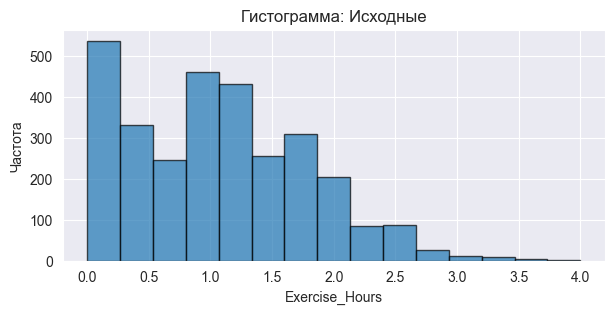

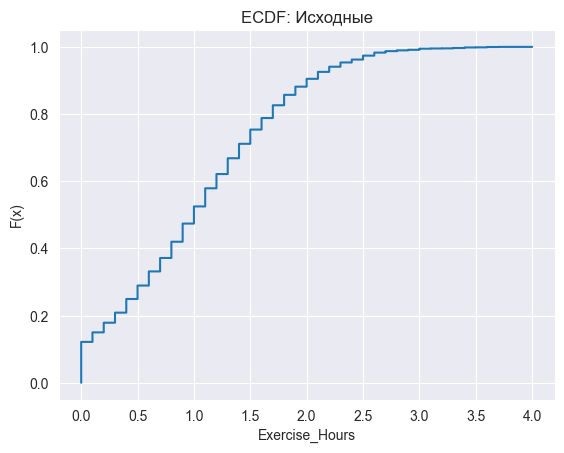

χ² = 688.96; крит. знач. = 18.31 (df=10)
❌ Гипотеза нормальности ОТКЛОНЯЕТСЯ (χ² > крит)


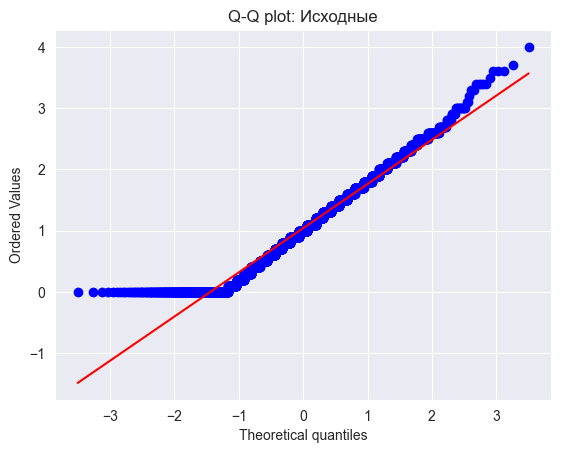

In [89]:
res_raw = analyze_data(data, 'Исходные', plot_hist=True)

**Числовые характеристики:**
- Среднее: 1.041, медиана: 1.000, мода: 0.00. Значит, большинство значений близки к 1.0, есть небольшой перекос к меньшим значениям. Есть накопления нулей (исходя из моды).
- Дисперсия: 0.540. Разброс невелик.
- Квантили (0.25/0.5/0.75): 0.5 / 1.0 / 1.5. Интерквартильный размах = 1.0.
- Эксцесс: -0.26, асимметрия: 0.44 -- немного правостороннее распределение, хвост длиннее справа, распределение слегка "приплюснуто" (более плоское относительно нормального).
- Гистограмма и ЭФР показывают, что данные сосредоточены около 0–1.5, есть некоторое количество нулевых значений.
В общем – распределение слегка асимметрично вправо (правостороннее), с небольшой склонностью к плоскости (негативный эксцесс)

- **Тесты нормальности:**
- Распределение НЕ нормально.
- Q-Q plot подтверждает: точки лежат не на прямой, хвосты отклоняются.

**Вывод:**
Данные исходно НЕ подчиняются нормальному распределению. Распределение слегка асимметрично вправо (правостороннее), с небольшой склонностью к плоскости (негативный эксцесс). Есть некоторое число выбросов (0).


## 3. Анализ измененых данных


Удалено выбросов: 17

--- Без выбросов ---
  Среднее: 1.027
  Дисперсия: 0.510
  Мода: 0.0
  Медиана: 1.000
  Квантили 0.25/0.5/0.75: 0.400, 1.000, 1.500
  Эксцесс: -0.641
  Асимметрия: 0.318
  Интерквартильный размах: 1.100


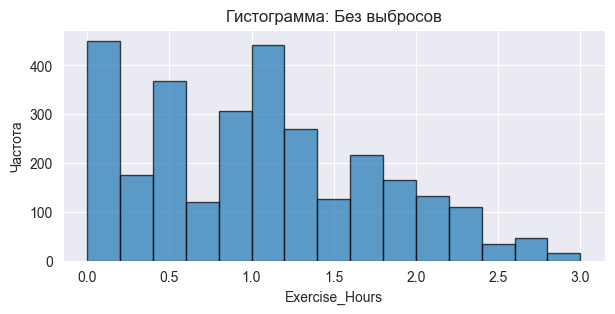

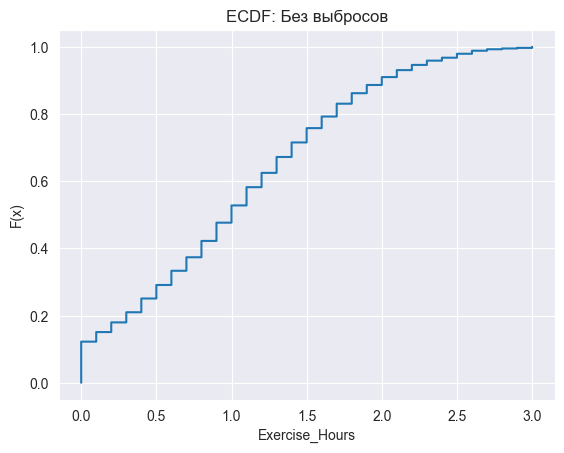

χ² = 901.91; крит. знач. = 18.31 (df=10)
❌ Гипотеза нормальности ОТКЛОНЯЕТСЯ (χ² > крит)


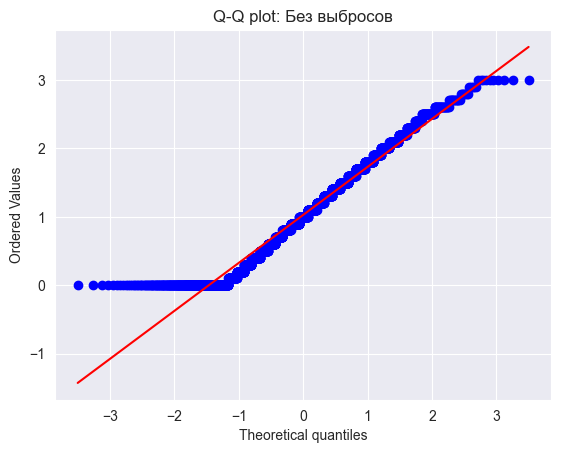

In [90]:
# 1. Данные без выбросов
Q1, Q3 = data.quantile([0.25, 0.75])
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
data_wo = data[(data >= lower) & (data <= upper)]
print(f"\nУдалено выбросов: {len(data) - len(data_wo)}")
res_wo = analyze_data(data_wo, 'Без выбросов', plot_hist=True)

- После удаления выбросов изменений мало: среднее и размах почти не изменились.
- Тест χ² = 901.91 по-прежнему сильно больше критического, нормальности не достигли.
- Гистограмма стала чуть ровнее, асимметрия снизилась (0.32), эксцесс уменьшился (−0.64).

**Вывод:**
Удаление выбросов не помогло добиться нормальности -- распределение по-прежнему существенно отличается от нормального.



--- Стандартизированные ---
  Среднее: 0.000
  Дисперсия: 1.000
  Мода: -1.416605979434427
  Медиана: -0.055
  Квантили 0.25/0.5/0.75: -0.736, -0.055, 0.625
  Эксцесс: -0.259
  Асимметрия: 0.438
  Интерквартильный размах: 1.361


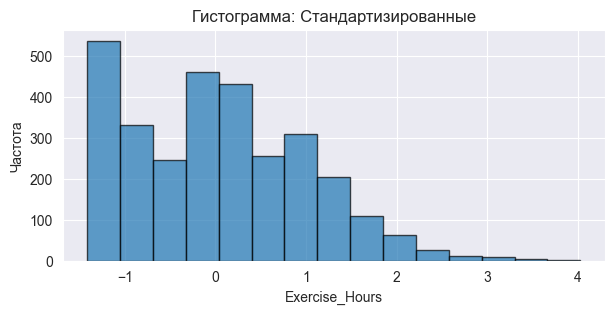

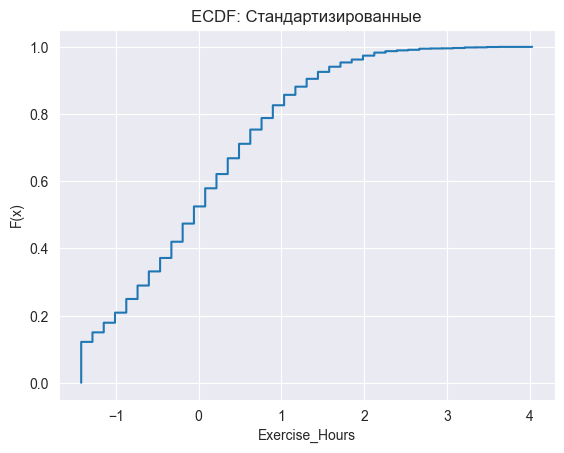

χ² = 688.96; крит. знач. = 18.31 (df=10)
❌ Гипотеза нормальности ОТКЛОНЯЕТСЯ (χ² > крит)


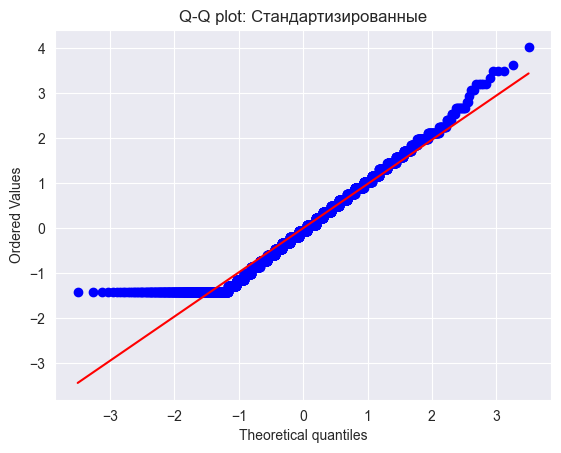

In [91]:
# 2. Стандартизация
data_std = (data - data.mean()) / data.std(ddof=1)
res_std = analyze_data(data_std, 'Стандартизированные', plot_hist=True)

- Все показатели сдвинулись: среднее 0, дисперсия 1 (что и ожидалось).
- Форма распределения не изменилась, χ², асимметрия, эксцесс не изменились по сути.
- Графики – прежний вид.

**Вывод:**
Стандартизация не приводит исходное распределение к нормальному, она только меняет масштаб и "центр" без изменения формы.



--- log1p ---
  Среднее: 0.645
  Дисперсия: 0.142
  Мода: 0.0
  Медиана: 0.693
  Квантили 0.25/0.5/0.75: 0.405, 0.693, 0.916
  Эксцесс: -0.847
  Асимметрия: -0.249
  Интерквартильный размах: 0.511


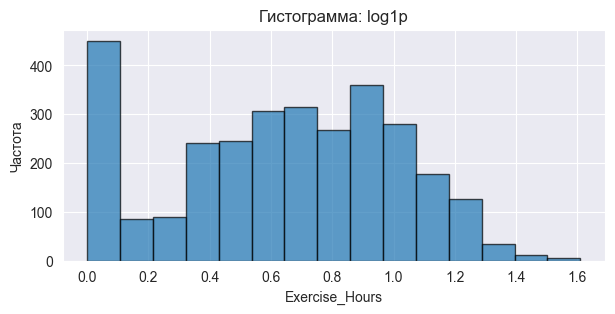

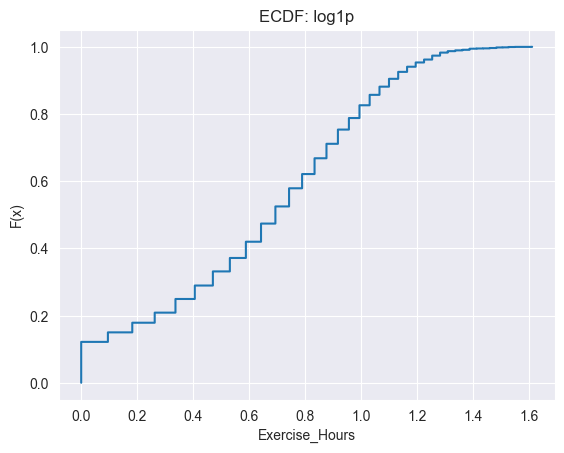

χ² = 1223.30; крит. знач. = 18.31 (df=10)
❌ Гипотеза нормальности ОТКЛОНЯЕТСЯ (χ² > крит)


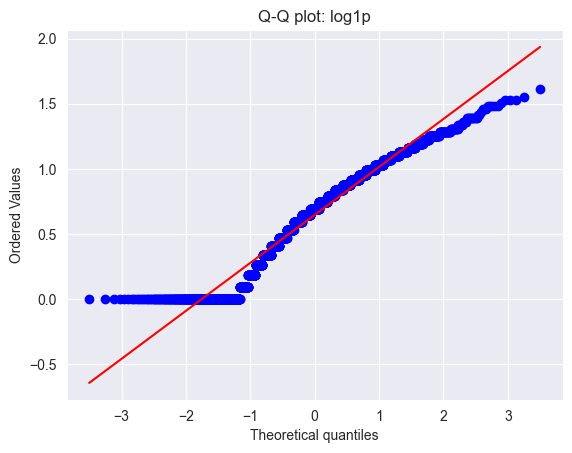

In [92]:
# 3. Логарифмирование
if (data <= 0).any():
    data_log = np.log1p(data)
else:
    data_log = np.log(data)
res_log = analyze_data(data_log, 'log1p', plot_hist=True)

- Средние значения и разброс уменьшились, асимметрия стала ближе к 0 (−0.25), эксцесс стал ещё ниже (−0.85) — распределение стало более симметричным.
- Однако χ² = 1223.30 (ещё выше). Гистограмма — всё ещё далека от нормальной формы.
- Q-Q plot — большие отклонения в хвостах.

**Вывод:**
Логарифмическое преобразование немного симметризовало данные, но не сделало их нормальными. Форма по-прежнему далека от нормального закона.


**Общий вывод по п. III:**
Никакой из рассмотренных простых методов (удаление выбросов, стандартизация, логарифмирование) не сделал данные нормально распределёнными. Причина — наличие моды в 0, несимметричность данных.


## 4. Группировка по School_Grade

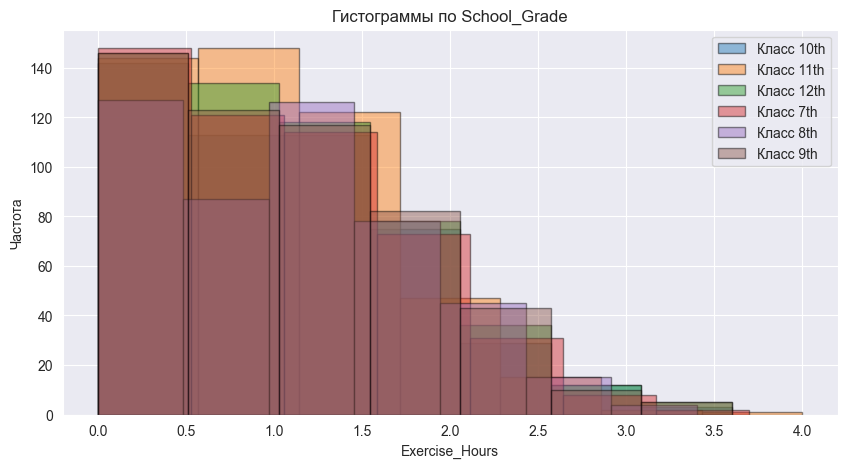

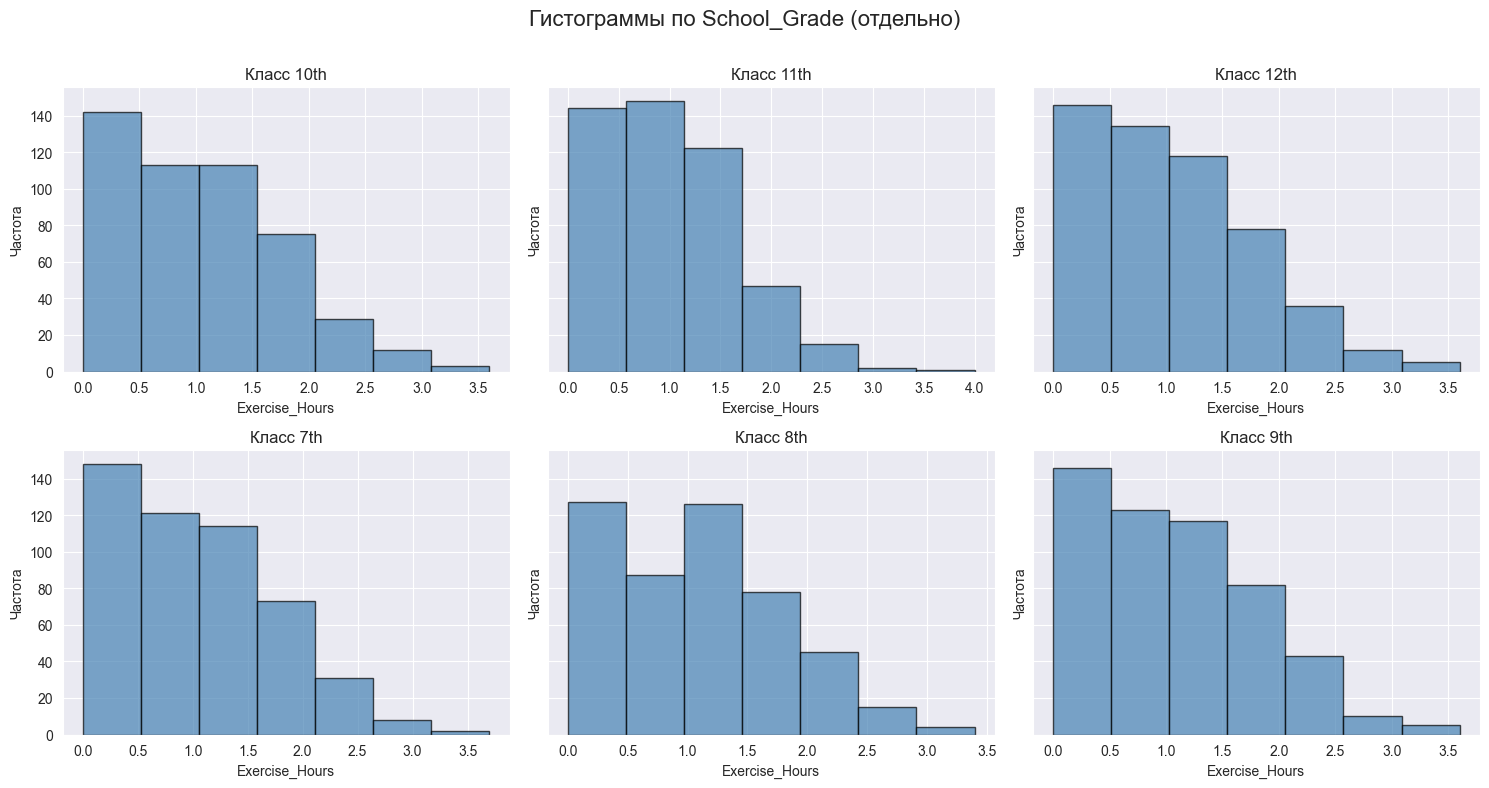


Средние и дисперсии по классам:
  Класс 10th: среднее = 1.043, дисперсия = 0.537
  Класс 11th: среднее = 0.980, дисперсия = 0.487
  Класс 12th: среднее = 1.046, дисперсия = 0.564
  Класс 7th: среднее = 1.030, дисперсия = 0.532
  Класс 8th: среднее = 1.062, дисперсия = 0.552
  Класс 9th: среднее = 1.080, дисперсия = 0.562


In [93]:
import math
import matplotlib.pyplot as plt

grades = sorted(df['School_Grade'].unique())
n_grades = len(grades)

# общая гистограмма
plt.figure(figsize=(10,5))
for grade in grades:
    group = df[df['School_Grade'] == grade][col].dropna()
    plt.hist(
        group, bins=7, alpha=0.45, edgecolor='black',
        label=f'Класс {grade}'
    )
plt.title('Гистограммы по School_Grade')
plt.xlabel(col)
plt.ylabel('Частота')
plt.legend()
plt.show()

# индивидуальные гистограммы (по 3 в ряд)
ncols = 3
nrows = math.ceil(n_grades / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), sharey=True)
axes = axes.flatten()

for i, grade in enumerate(grades):
    group = df[df['School_Grade']==grade][col].dropna()
    axes[i].hist(group, bins=7, alpha=0.7, color='steelblue', edgecolor='black')
    axes[i].set_title(f'Класс {grade}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')

# для пустых ячеек (если классов не кратно 3) скрываем лишние оси
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle('Гистограммы по School_Grade (отдельно)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


# Среднее и дисперсия внутри каждой группы
print("\nСредние и дисперсии по классам:")
for grade in grades:
    group = df[df['School_Grade']==grade][col].dropna()
    mu = group.mean()
    var = group.var(ddof=1)
    print(f"  Класс {grade:>2}: среднее = {mu:.3f}, дисперсия = {var:.3f}")


- Гистограммы по классам показывают очень похожую структуру: почти во всех классах мода ~0 или 1, среднее лежит в диапазоне 0.98–1.08, дисперсия — 0.48–0.56.
- Значимые различия между классами отсутствуют, кривые практически совпадают.
- Внутригрупповой разброс мала, перекосов нет.
- Структура распределений одинакова: есть много нулевых и единичных значений, что связано со спецификой переменной (‘Time_on_Education’ это по сути балльная оценка или счётчик).

**Вывод:**
Между различными School_Grade — распределения исследуемого столбца похожи, существенных различий по среднему и дисперсии нет. Основные характеристики одни и те же: пик около 0–1, разброс малый.
